Basic Analysis
============

This notebook aims to do a basic analysis of the data set. In particular, this will cover the correlation between different variables in the test set, a simple decision tree classifier and performance of different dimensional reduction techniques. To cover some basics:

Size of training and test data
------------------------------------------
There are 200,000 training values, with 200 dimensions of information. The approximate distribution of target values, as will be shown, is 90% are 0's and 10% are 1's. The test set that has to be submitted also contains 200,000 test values. 

The overall size of the data is relatively small, so it can be loaded entirely into RAM locally without issue. Thus, the training and test data has been read from the .csv files and outputted into .npy (numpy compressed) formats to speed up loading in the future. The class `DataWorker`, will automatically load the data and perform basic tests and modifications of the data and the predicted results. 


Initial Analysis
---------------------

Data is loaded and correlations of the inputs are computed to look for any generic patterns.

**Conclusions:**
Most of the data has very little correlation with eachother suggesting most of the dimensions are linearly independent of eachother (largets correlation coefficient is 0.01). Does not meant there isn't a non-linear correlation between some dimensions, but initially, this data looks promisingly easy to work with.

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import sklearn #SciKit-learn, good ML package
from sklearn.externals import joblib #for dumping and loading learned classifiers
from sklearn import tree as sktree
import os
import time
import matplotlib.pyplot as plt

from load import DataWorker #custom class for working with the data worker

cwd = os.getcwd()
ld = DataWorker() #load the data into the class
print("Size of training set: %d" % ld.n_training)
print("Number of input dimensions: %d" % ld.n_inputs)
print("Size of test set: %d" % ld.n_tests)



Size of training set: 200000
Number of input dimensions: 200
Size of test set: 200000


In [3]:
R = np.corrcoef(ld.training, rowvar=False) # calculate correlation coefficient between all dimensions
assert np.shape(R)[0] == ld.n_inputs

# zero out the diagonal, since of course it's 1!
for i in range(ld.n_inputs):
    R[i,i] = 0

print("largest correlation coefficient: %f" % np.max(np.abs(R)))

largest correlation coefficient: 0.009844


Analysis of Simple Decision Tree
-------------------------------------------------

A simple decision tree is computed on all the data, with no cross-validation checks to prevent over-fitting. This is meant to provide a benchmark of the performance of a dumb classifier, as well as provide basic insight into what we're working with.

**Conclusions:**
The simple Decision Tree does a very poor job. After submitting to Kaggle, the resultant accuracy was ~54%. Interestingly, the percentage of zeros in both data sets is about the same, meaning that the test set contains many more positive examples than the training set. The decision tree definitely overfits the data. Some attempts to prevent overfitting will be outlined in the following sections.

In [4]:
work_dir = "%s/simple_decision_tree" % cwd

os.chdir(work_dir)
simple_tree = joblib.load("simple_tree.pkl") # load pre-computed results from a crude decision tree, see decision_tree.py
results = simple_tree.predict(ld.tests) #Compute Predictions (kaggle gives ~54% accuracy)

os.chdir(cwd)
a_zeros, a_ones = ld.find_number_classified(ld.targets)
b_zeros, b_ones = ld.find_number_classified(results)

print("Training set: %f are zeroes" % (a_zeros / (a_zeros + a_ones))) #percentage of zeros in the training set
print("Test set: %f are zeroes" %( b_zeros / (b_zeros + b_ones))) #percentage of zeros in the test set


Training set: 0.899510 are zeroes
Test set: 0.892875 are zeroes


Cross Validation Check of Tree Depth
-------------------------------------------------

One option is to perform a cross-validation check for some hyper parameters. Sinver over-fitting seems to be an issue, let's try to reduce the tree depth. Let's handle this with a maximum tree depth. The default cross-validation score was used for the decision tree tree, which is the "mean accuracy" score (see: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter sec 3.3.2.2). As a note, all scikit-learn scores are always set up so bigger numbers mean more accurate. 

**Conclusions:** An inflection point is reached around 1000. However, this is accuracy, and that's awful considering the accuracy would be ~90% when considering only 0's. This intuition ended up being correct, as the accuracy of the test model has become 0.504 for the MSS of 1000 and 0.499 for the MSS of 6000. Clearly, it's just a fancy way of outputting 0's. Maybe cross validate and only count accuracy of 1's predictions?

K-Fold Cross Validation performed for 10 parameter values with 10 sets
[0.83519499 0.83797002 0.83833002 0.84122004 0.85225496 0.86471002
 0.89313001 0.89646501 0.89911    0.89941   ]
1000.0


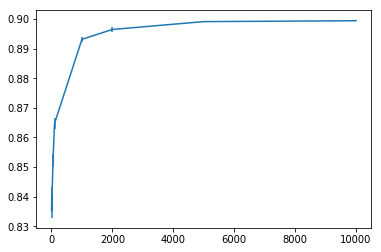

In [5]:
#Load cv scores
min_split_criteria = np.loadtxt("simple_decision_tree/cv_min_split.dat")
cv_scores = np.loadtxt("simple_decision_tree/cv_scores.dat")

n_parameters, n_sets = np.shape(cv_scores)

print("K-Fold Cross Validation performed for %d parameter values with %d sets" % (n_parameters, n_sets))

averages = np.sum(cv_scores, axis=1) / n_sets

# make sure this works as expected
#test = np.zeros(np.shape(cv_scores))
#test = test - averages[:,np.newaxis]
#assert test[0,0] == test[0,1]
#assert test[1,0] == test[1,1]

sd = np.sqrt(np.sum((cv_scores - averages[:,np.newaxis]) ** 2, axis=1) / n_sets)

plt.errorbar(min_split_criteria, averages, sd)

print(averages)
print(min_split_criteria[6])




In [8]:
# load the resultant trees
mss1 = np.loadtxt("simple_decision_tree/submission_mss1000.csv", skiprows=1, usecols=(1,), delimiter=",")
mss6 = np.loadtxt("simple_decision_tree/submission_mss1000.csv", skiprows=1, usecols=(1,), delimiter=",")

a_zeros, a_ones = ld.find_number_classified(mss1)
b_zeros, b_ones = ld.find_number_classified(mss6)

print("Minimal Sample Split of 1000: %f are zeroes" % (a_zeros / (a_zeros + a_ones))) 
print("Minimal Sample split of 6000: %f are zeroes" %( b_zeros / (b_zeros + b_ones))) 

Minimal Sample Split of 1000: 0.991460 are zeroes
Minimal Sample split of 6000: 0.991460 are zeroes


Cross Validation Using Weighted Accuracy
---------------------------------------------------------------

The previous Cross-Validation checked scored using an unweighted accuracy. However, this resulted in a decision tree that was much worse as it classified the majority of inputs as 0. By weighting the 1's significantly more (9-times more than the 0's) in the cross-validation scoring, maybe it would help clear things up.


**Conclusions:** This is very interesting. So there is an ideal decision tree with a minimum split criteria of 20. I think I didn't think about the impurity decrease very well, it appears the values I inputted are essentially all identical. Strange, a Gini score of 0.5 is the maximum Gini score for a binary classification process, so setting a minimum decrease of 0.5 seems like it should essentially stop the search process. It's possible that the Gini score decrease at each leaf node is itself super tiny and setting any value other than 0 causes it to immediately freeze. Will have to investigate further. In the end, using a minimum leaf split of 20 means an accuracy of 56%, so this is a slight improvement. Time to move on to something more complex.

K-Fold Cross Validation performed for 10 parameter values with 10 sets
[0.55671269 0.55920161 0.55990564 0.5603934  0.55840336 0.54539272
 0.53145629 0.51359536]
20.0


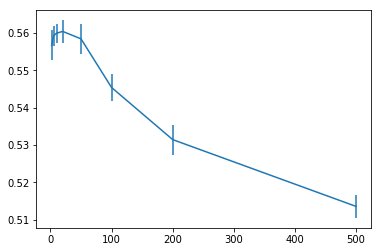

In [11]:
#Load cv scores for a minimum sample split
min_split_criteria = np.loadtxt("simple_decision_tree/cv_acc9_sample-count_values.dat")
min_split_scores = np.loadtxt("simple_decision_tree/cv_acc9_sample-count_scores.dat")

n_parameters, n_sets = np.shape(cv_scores)

print("K-Fold Cross Validation performed for %d parameter values with %d sets" % (n_parameters, n_sets))

averages = np.sum(min_split_scores, axis=1) / n_sets

# make sure this works as expected
#test = np.zeros(np.shape(cv_scores))
#test = test - averages[:,np.newaxis]
#assert test[0,0] == test[0,1]
#assert test[1,0] == test[1,1]

sd = np.sqrt(np.sum((min_split_scores - averages[:,np.newaxis]) ** 2, axis=1) / n_sets)

plt.errorbar(min_split_criteria, averages, sd)

print(averages)
print(min_split_criteria[3])

K-Fold Cross Validation performed for 10 parameter values with 10 sets
[0.49864185 0.49864185 0.49864185 0.49864185 0.49864185 0.49864185
 0.49864185]
20.0


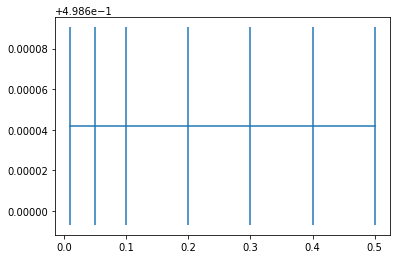

In [13]:
#Load cv scores for a impurity score
impurity_criteria = np.loadtxt("simple_decision_tree/cv_acc9_impurity_values.dat")
impurity_scores = np.loadtxt("simple_decision_tree/cv_acc9_impurity_scores.dat")

n_parameters, n_sets = np.shape(cv_scores)

print("K-Fold Cross Validation performed for %d parameter values with %d sets" % (n_parameters, n_sets))

averages = np.sum(impurity_scores, axis=1) / n_sets

# make sure this works as expected
#test = np.zeros(np.shape(cv_scores))
#test = test - averages[:,np.newaxis]
#assert test[0,0] == test[0,1]
#assert test[1,0] == test[1,1]

sd = np.sqrt(np.sum((impurity_scores - averages[:,np.newaxis]) ** 2, axis=1) / n_sets)

plt.errorbar(impurity_criteria, averages, sd)

print(averages)
print(min_split_criteria[3])

In [17]:
# load the decision tree computed with a minimum sample split of 20
best_tree = joblib.load("simple_decision_tree/simple_tree_min_sample_split20.pkl")
best_predictions = best_tree.predict(ld.tests)
ld.output_results(best_predictions, savename="simple_decision_tree/submission_mss20.csv")

a_zeros, a_ones = ld.find_number_classified(best_predictions)
print("Best Tree found: %f are zeroes" % (a_zeros / (a_zeros + a_ones))) #percentage of zeros in the test set


Best Tree found: 0.899905 are zeroes
